### Imports

In [ ]:
from IPython.display import clear_output

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats as stats
import keras
import keras.layers as layers

## Test a Distribution

<IPython.core.display.Javascript object>


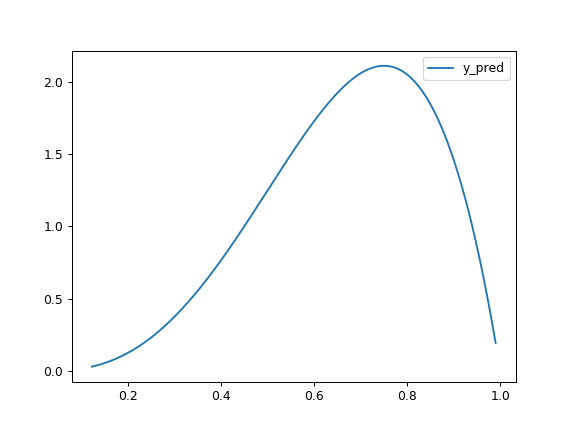

In [133]:
distribution = stats.beta
args = (4,2)
lim = (10**-3,10**-3)

y_x = np.linspace(distribution.ppf(lim[0], *args), distribution.ppf(1-lim[1], *args), n_y)
y = distribution.pdf(y_x, *args)
      
plt.figure()
plt.plot(y_x, y, label='y_pred')
plt.legend()

## Dataset

### Select Distributions

In [ ]:
set_distributions = [stats.norm, stats.t, stats.powernorm, stats.beta]
arg_placeholders = [list(), (None,), (None,), (None, None)]

In [128]:
distributions = list()
lims = list()
distrib_args = list()
n_type = 10
for distribution in set_distributions:
    

TypeError: 'module' object is not iterable

### Generate Curves

In [110]:
y_power = 10
n_y = 2**y_power

y_x = np.nan * np.ones((len(distributions),n_y))
y_pdf = np.nan * np.ones((len(distributions),n_y))
for i, distribution, args, lim in zip(range(len(distributions)),distributions,distrib_args, lims):
    y_x[i,:] = np.linspace(distribution.ppf(lim[0], *args), distribution.ppf(1-lim[1], *args), n_y)
    y = distribution.pdf(y_x[i,:], *args)
    y.reshape((1, y.size))    
    y_pdf[i,:] = y
    
n_x = list(set([ j * 2**i for i in range(1,y_power) for j in (2,3,5)]))
n_x = np.array(n_x)
n_x.sort()
x_x_list = list()
x_pdf_list = list()
y_list = list()
for n in n_x:  
    x_x = np.nan * np.ones((len(distributions),n))
    x_pdf = np.nan * np.ones((len(distributions),n))
    for i, distribution, args, lim in zip(range(len(distributions)),distributions,distrib_args, lims):
        x_x[i,:] = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n) 
        x_pdf[i,:] = distribution.pdf(x_x[i,:],*args)
    x_x_list.append(x_x)
    x_pdf_list.append(x_pdf)

n_x: 12


<IPython.core.display.Javascript object>


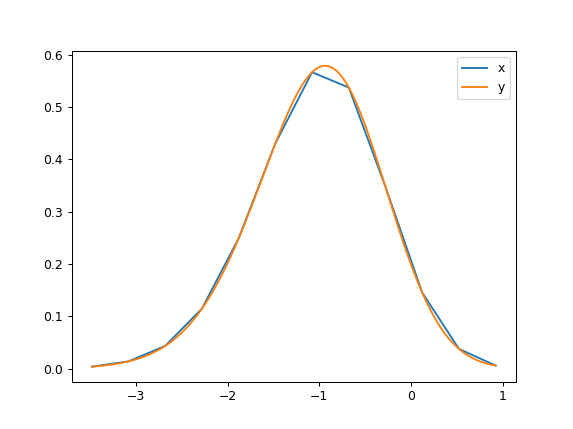

In [113]:
sample_index = 4
distribution_index = 2
print('n_x: {0}'.format(n_x[sample_index]))
plt.figure()
plt.plot(x_x_list[sample_index][distribution_index,:], 
         x_pdf_list[sample_index][distribution_index,:], label='x')
plt.plot(y_x[distribution_index,:], y_pdf[distribution_index,:], label='y')
plt.legend()

## Keras Model

In [114]:
keras.backend.clear_session()

n_a = 100

encoder_LSTM = layers.Bidirectional(layers.LSTM(units = n_a, return_state=True))
decoder_LSTM = layers.Bidirectional(layers.LSTM(units = n_a, return_sequences=True))

flatter = layers.Flatten()
dense = layers.Dense(units = 10, activation='tanh')
tanh_out = layers.Dense(units = n_y, activation='tanh')

In [115]:
def define_model(n_a):
    
    x_input = keras.layers.Input(shape=(None, 1))
    
    _, for_encoder_h, for_encoder_c, back_encoder_h, back_encoder_c = encoder_LSTM(x_input)  
    
    decoder_input = keras.layers.Input(shape=(1,n_a))
    deco_input = decoder_input
    
    decoder_outputs = decoder_LSTM(deco_input, initial_state=[for_encoder_h, for_encoder_c, back_encoder_h, back_encoder_c])
    decoder_outputs_flat = flatter(decoder_outputs)
    out = dense(decoder_outputs_flat)
    out = tanh_out(out)
    
    
    model = keras.models.Model(inputs=[x_input, decoder_input], outputs=out)
    return model

In [116]:
model = define_model(n_a)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 100)       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 200), (None, 81600       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 1, 200)       160800      input_2[0][0]                    
                                                                 bidirectional_1[0][1]            
          

In [117]:
optim = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])

In [119]:
decoder_in = np.zeros((x_pdf_list[0].shape[0],1,n_a))
for x_pdf in x_pdf_list:
    x_pdf = x_pdf.reshape((x_pdf.shape[0],x_pdf.shape[1],1))
    model.fit(x=[x_pdf, decoder_in], y=y_pdf, epochs=5)

Epoch 1/10
3/3 [==============================] - 4s 1s/step - loss: 0.0488 - acc: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 0s 5ms/step - loss: 0.0485 - acc: 0.0000e+00
Epoch 3/10
3/3 [==============================] - 0s 4ms/step - loss: 0.0482 - acc: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 0s 4ms/step - loss: 0.0479 - acc: 0.0000e+00
Epoch 5/10
3/3 [==============================] - 0s 4ms/step - loss: 0.0475 - acc: 0.0000e+00
Epoch 6/10
3/3 [==============================] - 0s 4ms/step - loss: 0.0471 - acc: 0.0000e+00
Epoch 7/10
3/3 [==============================] - 0s 4ms/step - loss: 0.0468 - acc: 0.0000e+00
Epoch 8/10
3/3 [==============================] - 0s 4ms/step - loss: 0.0464 - acc: 0.0000e+00
Epoch 9/10
3/3 [==============================] - 0s 4ms/step - loss: 0.0459 - acc: 0.0000e+00
Epoch 10/10
3/3 [==============================] - 0s 3ms/step - loss: 0.0454 - acc: 0.0000e+00
Epoch 1/10
3/3 [==============================] - 

3/3 [==============================] - 0s 11ms/step - loss: 0.0031 - acc: 0.0000e+00
Epoch 8/10
3/3 [==============================] - 0s 11ms/step - loss: 0.0030 - acc: 0.0000e+00
Epoch 9/10
3/3 [==============================] - 0s 11ms/step - loss: 0.0031 - acc: 0.0000e+00
Epoch 10/10
3/3 [==============================] - 0s 11ms/step - loss: 0.0026 - acc: 0.0000e+00
Epoch 1/10
3/3 [==============================] - 0s 12ms/step - loss: 0.0037 - acc: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 0s 12ms/step - loss: 0.0026 - acc: 0.0000e+00
Epoch 3/10
3/3 [==============================] - 0s 13ms/step - loss: 0.0038 - acc: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 0s 13ms/step - loss: 0.0024 - acc: 0.0000e+00
Epoch 5/10
3/3 [==============================] - 0s 12ms/step - loss: 0.0026 - acc: 0.0000e+00
Epoch 6/10
3/3 [==============================] - 0s 12ms/step - loss: 0.0025 - acc: 0.0000e+00
Epoch 7/10
3/3 [==============================] - 

Epoch 3/10
3/3 [==============================] - 0s 63ms/step - loss: 0.0043 - acc: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 0s 63ms/step - loss: 0.0025 - acc: 0.0000e+00
Epoch 5/10
3/3 [==============================] - 0s 64ms/step - loss: 0.0041 - acc: 0.0000e+00
Epoch 6/10
3/3 [==============================] - 0s 63ms/step - loss: 0.0032 - acc: 0.0000e+00
Epoch 7/10
3/3 [==============================] - 0s 64ms/step - loss: 0.0021 - acc: 0.0000e+00
Epoch 8/10
3/3 [==============================] - 0s 64ms/step - loss: 0.0048 - acc: 0.0000e+00
Epoch 9/10
3/3 [==============================] - 0s 63ms/step - loss: 0.0029 - acc: 0.0000e+00
Epoch 10/10
3/3 [==============================] - 0s 64ms/step - loss: 0.0063 - acc: 0.0000e+00
Epoch 1/10
3/3 [==============================] - 0s 78ms/step - loss: 0.0083 - acc: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 0s 77ms/step - loss: 0.0072 - acc: 0.0000e+00
Epoch 3/10
3/3 [=======================

Epoch 8/10
3/3 [==============================] - 1s 390ms/step - loss: 0.0068 - acc: 0.0000e+00
Epoch 9/10
3/3 [==============================] - 1s 383ms/step - loss: 0.0068 - acc: 0.0000e+00
Epoch 10/10
3/3 [==============================] - 1s 373ms/step - loss: 0.0068 - acc: 0.0000e+00
Epoch 1/10
3/3 [==============================] - 2s 616ms/step - loss: 0.0068 - acc: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 2s 617ms/step - loss: 0.0068 - acc: 0.0000e+00
Epoch 3/10
3/3 [==============================] - 2s 627ms/step - loss: 0.0068 - acc: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 2s 624ms/step - loss: 0.0068 - acc: 0.0000e+00
Epoch 5/10
3/3 [==============================] - 2s 631ms/step - loss: 0.0068 - acc: 0.0000e+00
Epoch 6/10
3/3 [==============================] - 2s 630ms/step - loss: 0.0068 - acc: 0.0000e+00
Epoch 7/10
3/3 [==============================] - 2s 718ms/step - loss: 0.0068 - acc: 0.0000e+00
Epoch 8/10
3/3 [=============

## Test Model

<IPython.core.display.Javascript object>


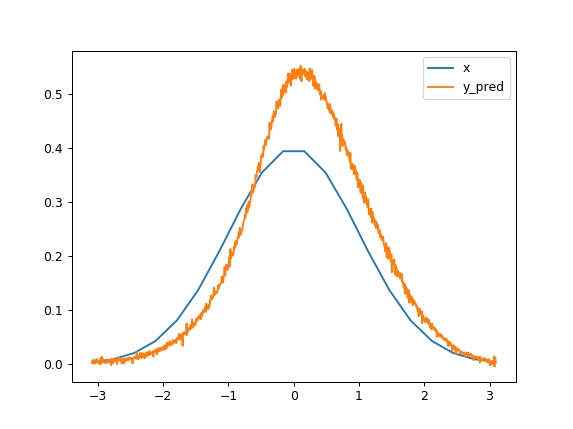

In [123]:
distribution = stats.powernorm
args = (1,)
lim = (10**-3,10**-3)
n = n_x[6]

x_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n) 
x_pdf = distribution.pdf(x_x,*args)
y_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n_y) 
y_pdf_true = distribution.pdf(y_x,*args)

decoder_in = np.zeros((x_pdf.shape[0],1,n_a))
x_pdf = x_pdf.reshape(1,x_pdf.size,1)
y_pdf_pred = model.predict(x=[x_pdf, decoder_in])

plt.figure()
plt.plot(x_x, x_pdf.flatten(), label='x')
plt.plot(y_x, y_pdf_pred.flatten(), label='y_pred')
plt.legend()